# Example GWAS - participant height

> We will use phenotypes produced by **Notebook 103**. This includes three sources of information about participant’s high blood pressure status: self-reported, ICD10 diagnoses and systolic blood pressure cut-offs, as well as values of blood pressure measurement. The phenotype data file also includes the `eid` identifier column, which allows us to match the rows in the `phenotype` table to corresponding genotypes saved in PLINK format. We will use linear and logistic models required for GWAS analyses using `bigstatsr` and `bigsnpr` packages (Privé, Aschard, and Blum 2017) in R.

- runtime: 30min 
- recommended instance: mem1_ssd1_v2_x16
- cost: ~£0.70

This notebook depends on:
* **Notebook 103** - file pheno_height_sex_age_500k.xlsx
* **Notebook 107** - maf_flt_8chroms* prefixed files

## Install required packages

Function `p_load` from `pacman` loads packages into R.
If a given package missing it will be automatically installed - this can take a considerable amount of time for packages that need C or FORTRAN code compilation.
The following packages are needed to run this notebook:

- `dplyr` - tabular data manipulation in R, require to pre-process, encoding and filter phenotypic data
- `parallel` - parallel computation in R
- `bigsnpr` - run statistics on file-backed arrays, needed to calculate the approximate singular value decomposition (SVD) needed for PCA plots
- `bigparallelr` - controls parallel computation using file-backed arrays
- `ggplot2` - needed for graphics
- `readr` - read and write tabular file formats: CSV, TSV, TDF, etc.
- `skimr` - provide summary statistics about variables in data frames

In [ ]:
#Load packages
if(!require(pacman)) install.packages("pacman")
pacman::p_load(dplyr, parallel, bigsnpr, bigparallelr, readxl, ggplot2, readr, skimr)

## Download and read phenotypes

The `pheno_height_sex_age_500k.xlsx` file can be created by following the example code in **Notebook 103** or running the [Table exporter](https://dnanexus.gitbook.io/uk-biobank-rap/working-on-the-research-analysis-platform/accessing-phenotypic-data-as-a-file).

In [2]:
system('dx download -f pheno/pheno_height_sex_age_500k.xlsx', intern = TRUE)

character(0)

In [ ]:
dat <- read_xlsx('pheno_height_sex_age_500k.xlsx')

At this point, you can inspect your data. For example, you can print 5 first rows using the `head(dat)` command.

## Preview phenotypes

In the example below we extract the vector of participant heights and calculate the basic summary statistics. 

In [3]:
height <- dat[['height']]
names(height) <- dat[['eid']]
summary(height)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   75.0   161.8   168.0   168.4   175.0   209.0    2539 

We can visualise the distribution of participant heights using kernel density estimates build in the `ggplot2` package. In the figure below we can observe the difference in height distributions between female and male participants.

Warning message:
“Removed 2722 rows containing non-finite values (`stat_density()`).”


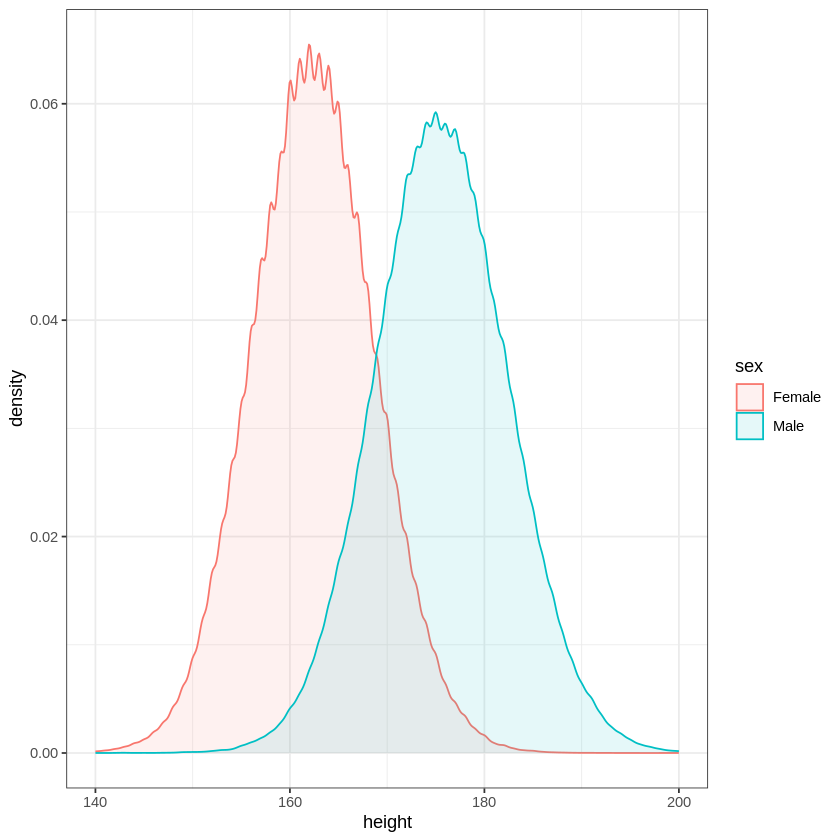

In [4]:
ggplot(dat, aes(height , colour = sex, fill = sex)) + 
  geom_density(alpha = 0.1) +
  xlim(c(140, 200)) +
  theme_bw()

## The correlation between height and putative covariates

The Pearson correlation coefficient is a useful statistical tool to understand the relationships between phenotypic variables. In the examples below we calculate the correlation between the height and participant’s age and biological sex. Using the `"complete.obs"` as `use` parameter allows the algorithm to skip the missing observation that is participants with no information about height, age or biological sex. Alternatively, we may use Spearman's method.

In [5]:
cor(dat$height, dat$age, use = 'complete.obs')

[1] -0.1065827

In [6]:
cor(dat$height, as.integer(factor(dat$sex)), use = 'complete.obs', method = 'spearman')

[1] 0.7287661

We can observe that height is weakly negatively correlated with participant age and correlated with biological sex. We might consider adding these variables to GWAS linear model as covariates, potentially increasing the model’s power to find causative variants. 

## Read and preview the plink bed/bim/fam files

The code below retrieves and reads into R the genomic variant data in PLINK format. See the notebook **103** to learn how to produce a common variant set from GWAS data, similar to the one used in this example notebook. The file we read in is `maf_flt_8chroms.bed` (representing chromosomes 1-8; see notebook **107**) - this and corresponding *bim* and *fam* files must be located in the notebook’s working directory. 

In [9]:
system('dx download -fr bed_maf/maf_flt_8chroms*', intern = TRUE)

character(0)

The `bigsnpr` package uses [Filebacked Big Matrices](https://privefl.github.io/bigstatsr/reference/FBM-class.html), which allows it to handle matrices that are too large to fit in memory. Hence, due to memory-mapping to binary files on disk, we first produce such files from PLINK formatted data and then attach them to the R environment.

In [7]:
bedfile <- normalizePath("maf_flt_8chroms.bed")
tmpfile <- normalizePath("bigsnpr_input", mustWork = FALSE)
if( length(dir(pattern=tmpfile)) ) unlink(dir(pattern=tmpfile))
snp_readBed(bedfile, backingfile = tmpfile)

[1] "/opt/notebooks/bigsnpr_input.rds"

After attaching the file we can observe it contains over 450,000 participants (data used is 450k WES cohort) and the number of variants

In [8]:
obj.bigSNP <- snp_attach(paste0(tmpfile, ".rds"))
obj.bigSNP$genotypes

A Filebacked Big Matrix of type 'code 256' with 469835 rows and 3767 columns.

## Sample 1500 individuals

In order to speed up calculations for this example notebook, we will sample 1500 participants out of the UKB cohort.

In [9]:
smpl <- sample(1:nrow(obj.bigSNP$fam), 1500)
sub.bigSNP <- snp_subset(obj.bigSNP , ind.row=smpl)
obj.bigSNP <- snp_attach(sub.bigSNP)
dim(obj.bigSNP$genotype)

[1] 1500 3767

## Filter for individuals with known height

To ensure the proper completion of the linear model used for GWAS we need to make sure there are no missing data in the phenotype vector.

In [10]:
height_smpl <- height[as.character(obj.bigSNP$fam$sample.ID)]
sub.bigSNP <- snp_subset(obj.bigSNP, ind.row=!is.na(height_smpl))
obj.bigSNP.height <- snp_attach(sub.bigSNP)
dim(obj.bigSNP$genotype)

[1] 1500 3767

In [11]:
height_smpl_flt <- height[as.character(obj.bigSNP.height$fam$sample.ID)]

## Calculate singular value decomposition (SVD) and visualize it as a PCA plot

In this step, we use the [partial SVD (or PCA) of a Filebacked Big Matrix](https://www.rdocumentation.org/packages/bigstatsr/versions/1.5.6/topics/big_randomSVD) to calculate covariates representing the population structure for the GWAS model. To learn more about the population structure see **Notebook 202**.

In [12]:
options(bigstatsr.check.parallel.blas = FALSE)
NCORES = nb_cores()
assert_cores(NCORES)
message('INFO: Using ', NCORES, ' cores')

G   <- obj.bigSNP.height$genotypes
CHR <- obj.bigSNP.height$map$chromosome
POS <- obj.bigSNP.height$map$physical.pos
ind.excl <- snp_indLRLDR(infos.chr = as.integer(as.factor(CHR)), infos.pos = POS)
ind.keep <- snp_clumping(G, infos.chr = as.integer(as.factor(CHR)),exclude = ind.excl,ncores = NCORES)
obj.svd <- big_randomSVD(G, fun.scaling = snp_scaleBinom(), ind.col = ind.keep, ncores = NCORES)

INFO: Using 35 cores



## Scree plot

Scree plot is an important diagnostic tool for PCA. It shows the singular value, which represents the fraction of variance captured by each component against the component index. On this plot, we can see that the first 3 components captured the majority of the variance in the data, meaning that the 10 PCs model is adequate to capture the population structure well.

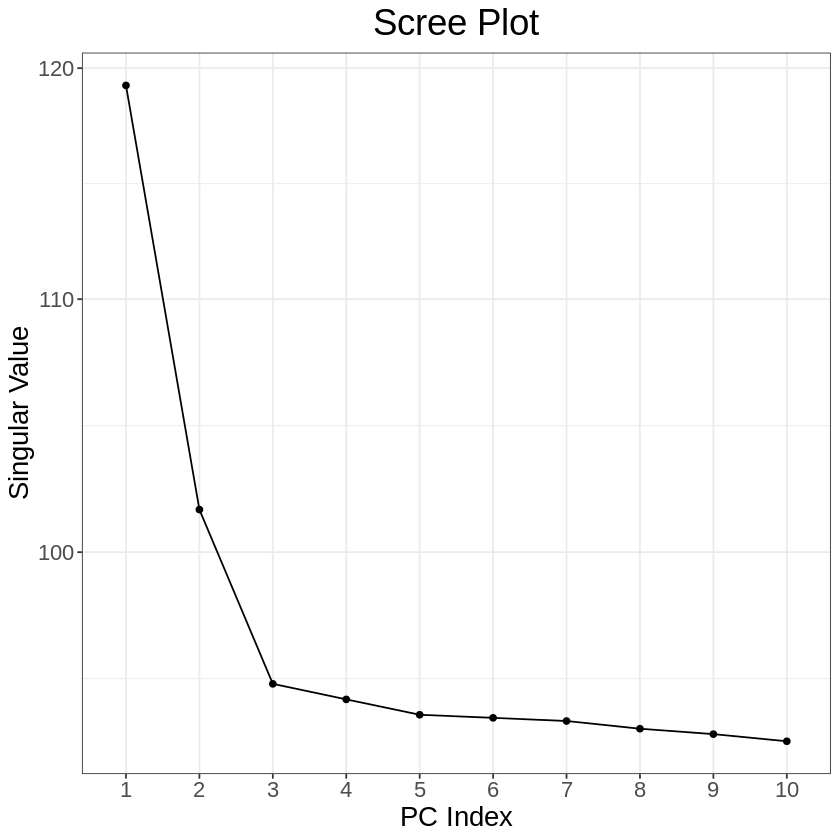

In [13]:
plot(obj.svd)

## PCA plot

The plot below visualizes the population structure (for sampled 1500 participants) by plotting PC1 against PC2. We see the expected clustering of sub-populations. See notebook **202** to learn more about these clusters. 

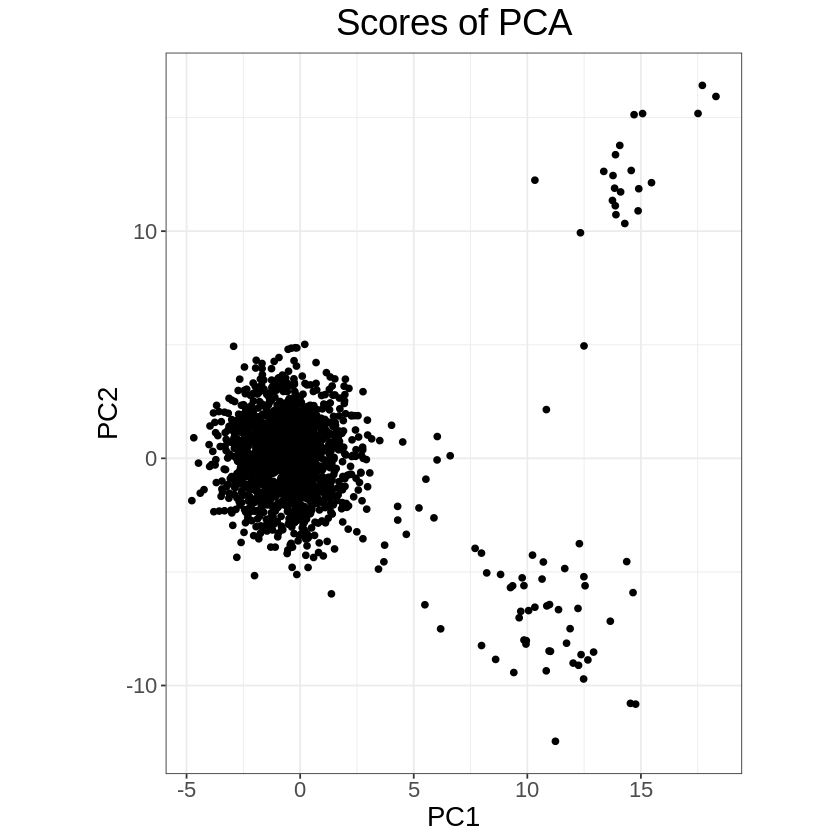

In [14]:
plot(obj.svd, type = "scores")

## PCA plot with participant height encoded as point colour

We can colour code the participant height and impose it on the PCA plot. On the plot below we can see that the participant height does not depend on population structure – participants of various heights can be found in all clusters.



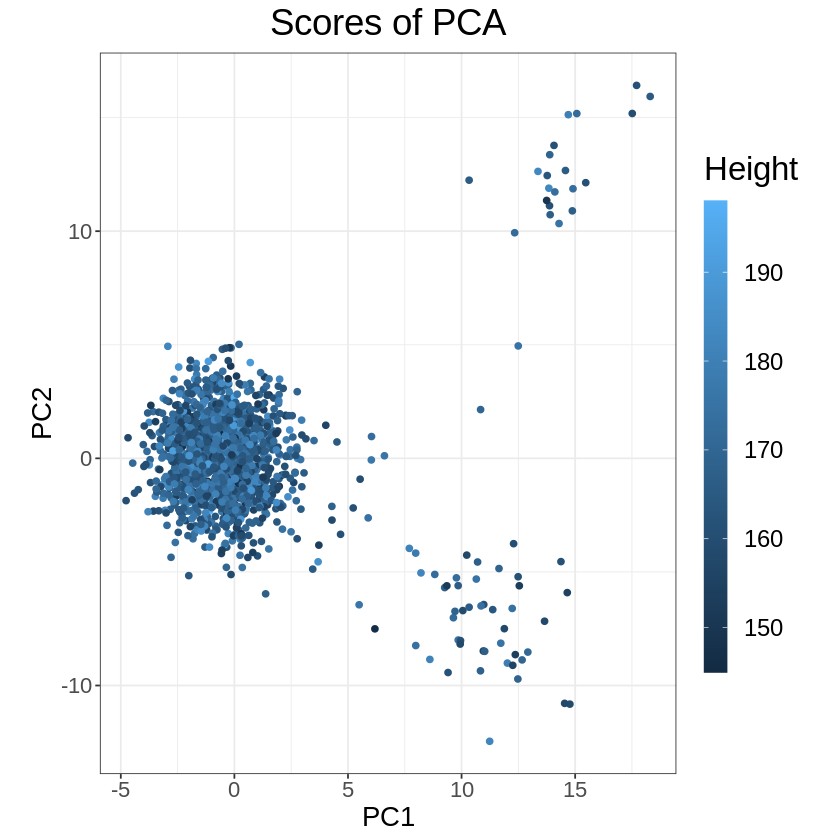

In [15]:
plot(obj.svd, type = "scores") + 
  aes(color = height_smpl_flt) +
  theme(legend.position="right", legend.key.width = unit(.5, 'cm'), legend.key.height = unit(2, 'cm')) +
  labs(color = "Height") 


## Running GWAS model

In this step, we are performing genome-wide association analyses using a linear regression implemented in `bigsnpr` package.

In [16]:
obj.gwas <- big_univLinReg(
  obj.bigSNP.height$genotypes, 
  y.train = height_smpl_flt,
  covar.train = obj.svd$u,
  ncores = NCORES
)

## Q-Q plot of the GWAS

We can diagnose the model performance with the quantile-quantile plot from p-values obtained by the GWAS model. We expect the observed and predicted values to be the same for most of the distribution (line up diagonally) and differ in the high statistical significance region (deviate from a diagonal line).

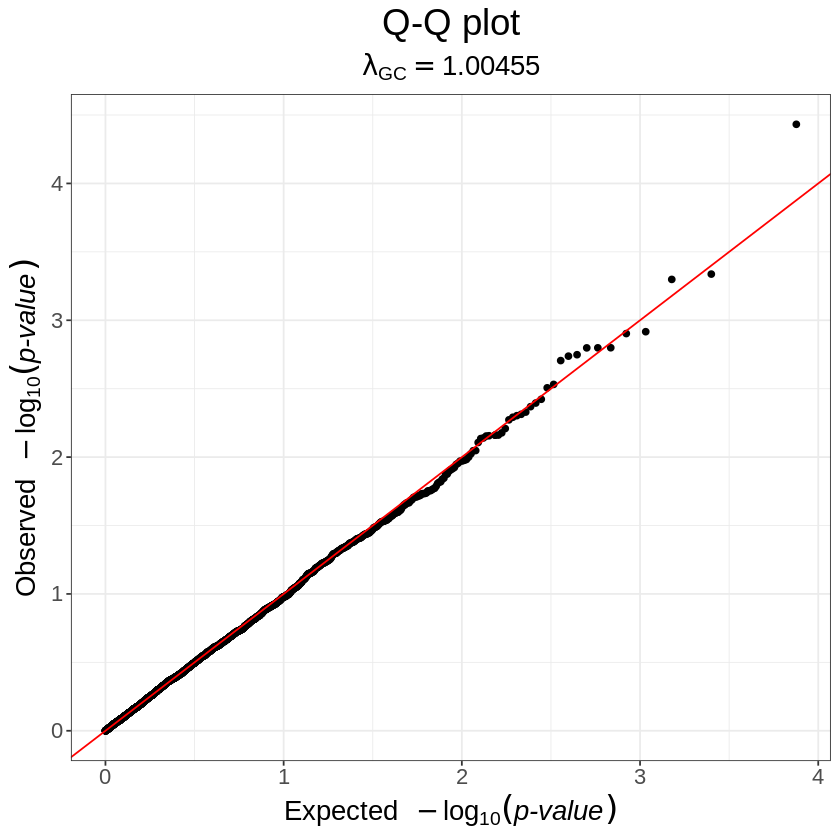

In [17]:
snp_qq(obj.gwas)

## Apply genomic control to GWAS and redo Quantile-Quantile (Q-Q) plot

We can apply a genomic control as defined in: 
> Devlin, B., & Roeder, K. (1999). Genomic control for association studies. Biometrics, 55(4), 997-1004.

The Q-Q plot below shows the impact of this procedure. 


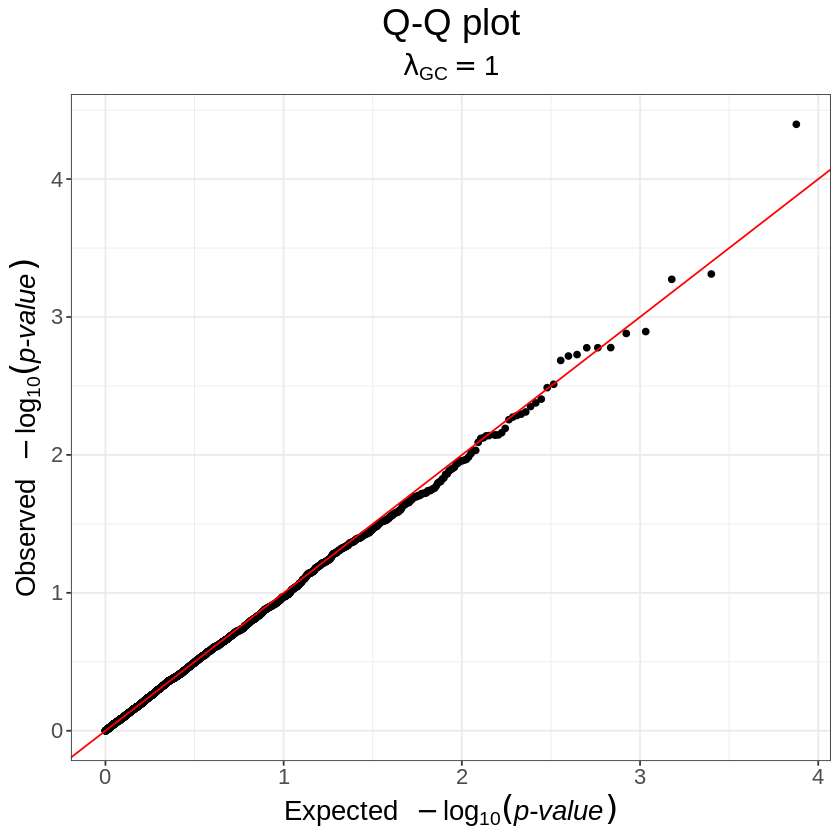

In [18]:
obj.gwas.gc <- snp_gc(obj.gwas)
snp_qq(obj.gwas.gc)

## Manhattan plots

Manhattan plots are very useful as a way to illustrate the significant variants and variant clustering in the genome. The X-axis represents the genomic position, while Y-axis show a negative log scaled p-value. This scaling allows us to show statistical significance intuitively – the most significant variants are represented at the top of the plot. 

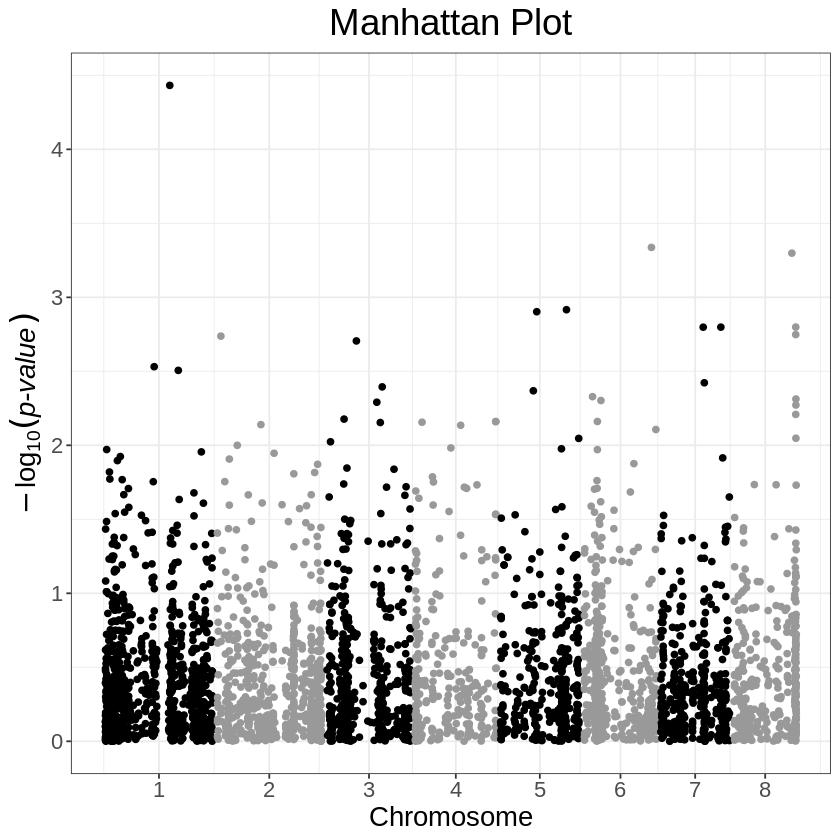

In [19]:
snp_manhattan(obj.gwas, infos.chr = as.integer(as.factor(CHR)), infos.pos = POS)

Similarly to the Q-Q plot above we can apply a genomic control as defined in: 
> Devlin, B., & Roeder, K. (1999). Genomic control for association studies. Biometrics, 55(4), 997-1004.


This procedure will not change the relative distances between the significance estimates (hence the plots are very similar). However, the estimation of the p-value will be more accurate (hence the difference on Y-axis).

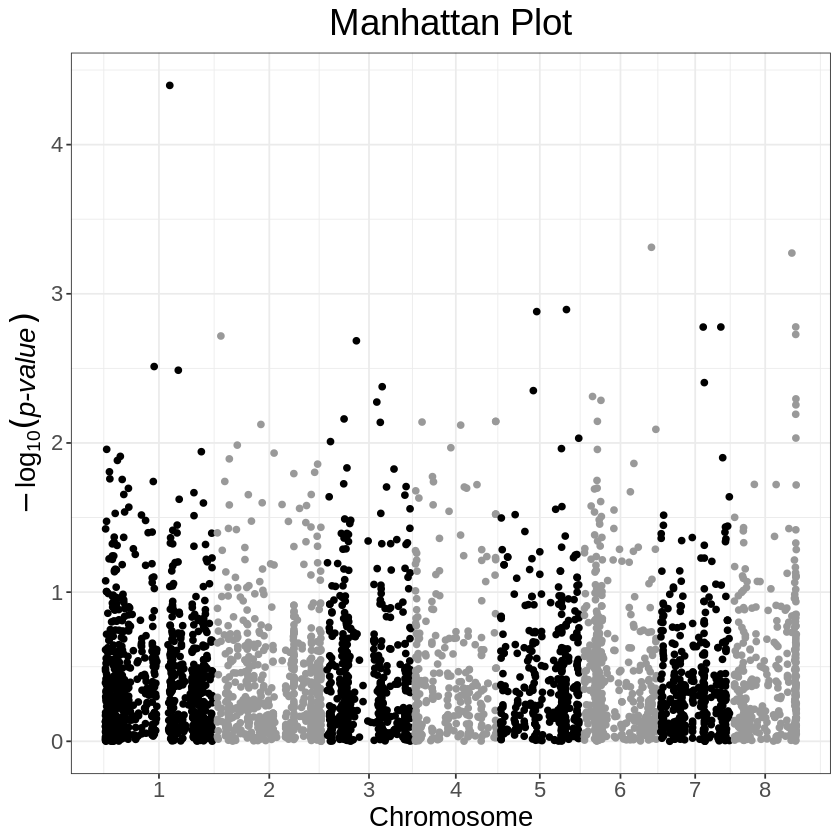

In [20]:
snp_manhattan(obj.gwas.gc, infos.chr = as.integer(as.factor(CHR)), infos.pos = POS)

## Volcano plot

The volcano plot is yet another very useful diagnostic tool for GWAS analyses. Similarly to the Manhattan plots, Y-axis denote a negative log scaled p-value. However, the X-axis show the estimate of the effect of the genomic variant on the phenotype. We expect variants with high effects (either positive or negative) to have a high statistical significance. Therefore, for a well fitted GWAS model, this plot should show a characteristic “volcano” pattern. 

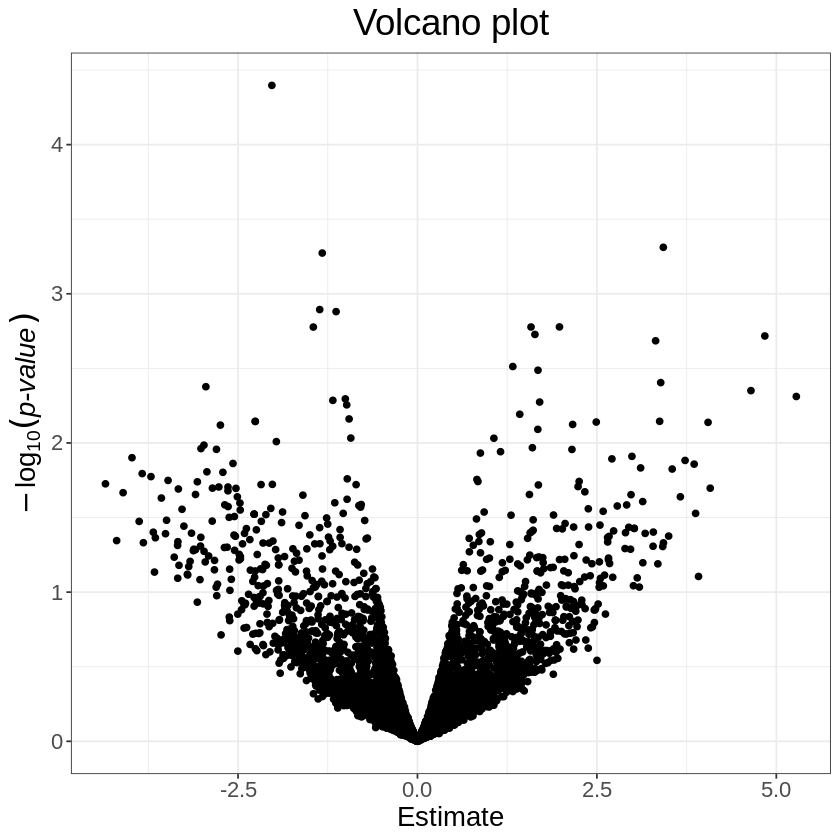

In [21]:
plot(obj.gwas.gc, type = "Volcano")

## Inspect the output of the GWAS model

We can examine the results of the GWAS model in a tabular view. The example table below includes the effect estimate (with standard error) and a model score for each variant. 

In [22]:
head(arrange(obj.gwas.gc, estim))

,estim,std.err,score
,<dbl>,<dbl>,<dbl>
1,-4.347409,1.839774,-2.363013
2,-4.191459,2.081032,-2.014125
3,-4.101592,1.774659,-2.311200
4,-3.977849,1.584495,-2.510484
5,-3.877800,1.814664,-2.136924
6,-3.835519,1.583940,-2.421506


# Predict p-values

Model scores can be used to estimate the statistical significance of each variant. This in turn allows us to rank the variants and apply a significance cut-off to limit the number of variants used for downstream analyses.

After p-value calculation, we can apply a correction for multiple hypothesis testing – a Benjamini & Hochberg method to obtain a false discovery rate (FDR) in this example.

In [23]:
obj.gwas.gc$p.value <- predict(obj.gwas.gc, log10 = FALSE)
obj.gwas.gc$fdr <- p.adjust(obj.gwas.gc$p.value, method = 'fdr')

In [24]:
obj.gwas.gc %>% arrange(p.value)  %>% head

,estim,std.err,score,p.value,fdr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-2.028742,0.4902520,-4.138162,4.007834e-05,0.1509751
2,3.425624,0.9756982,3.510946,4.879274e-04,0.6694857
3,-1.326660,0.3804696,-3.486902,5.331715e-04,0.6694857
4,-1.361947,0.4200630,-3.242245,1.275770e-03,0.7074049
5,-1.133874,0.3506989,-3.233184,1.316292e-03,0.7074049
6,1.978586,0.6253559,3.163936,1.667510e-03,0.7074049


## Filter the result based on p-value, add the genomic positions

Finally, we can apply a p-vale cut-off and concatenate the information from the genomic map to form a final tale containing the variant coordinates, type of substitution, variant ID and statistics obtained from the GWAS model. 

In [ ]:
signif <- cbind(obj.bigSNP.height$map, obj.gwas.gc) %>% arrange(p.value) %>% filter(p.value < 1e-3)
signif

## Export as a CSV file

The following table, exported to CSV format, will be used in further examples for functional annotations and visualization of variants.

In [27]:
signif  %>% readr::write_csv('height_signif_snp.csv')

## Save output to project

We will use this in notebook **208**

In [43]:
system('dx mkdir gwas')
system('dx upload height_signif_snp.csv --path gwas/')